In [32]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import yfinance as yf
import arch
from arch.univariate import Normal as ARCHNormal

from model.PDV import *
from model.data import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
window = 250                        # historical window for PDV
biz_days = False                # whether to use calendar days or trading days
use_log_ratio = True                # whether to use log ratio vs ratio
use_exog = False                    # whether to use exogenous variable in mean process
exog_col = 'log_vix_shift'           # column name for VIX in the data
n_lags = 1                          # number of lags for log ratio in mean process
res_window = 5                      # number of lags for residuals in volatility process
max_lag = max(n_lags, res_window)
n_sims = 9                          # number of simulations for multi-step forecasting
seed = 1

# Download data

In [34]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [35]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [36]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [37]:
spx_data = pd.read_csv('data/spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('data/vix_data.csv', index_col=0, parse_dates=[0])

In [38]:
data = create_df_from_yf(spx_data, train_start_date, test_start_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607
2018-12-26,0.048403,2.342868e-03,0.3041
2018-12-27,0.008526,7.269658e-05,0.2996
2018-12-28,-0.001242,1.543443e-06,0.2834


In [39]:
dataset = VIXDataset(data, window)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting with least squares

In [40]:
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
# initial_x = [0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5]
initial_x = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
res = least_squares(residual, initial_x, args=(data, window, False, biz_days), bounds=(lower_bound, upper_bound), verbose=2, ftol=1e-6)
res.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6616e+00                                    1.32e+02    
       1              2         3.4219e+00      2.40e-01       4.54e+00       6.55e+01    
       2              3         1.8924e+00      1.53e+00       1.20e+00       3.20e+00    
       3              4         1.8615e+00      3.10e-02       1.16e+00       6.41e+00    
       4              5         1.8412e+00      2.03e-02       2.33e+00       1.33e+00    
       5              6         1.8330e+00      8.23e-03       1.04e+01       5.34e+00    
       6              7         1.8269e+00      6.07e-03       4.67e+00       3.09e-01    
       7              8         1.8266e+00      2.82e-04       9.81e+00       1.89e+00    
       8              9         1.8261e+00      5.45e-04       2.34e+00       9.54e-04    
       9             12         1.8260e+00      1.54e-05       5.87e-01       5.82e-02    

array([ 5.90779123e-02, -2.41795499e-02,  8.72993071e-01,  1.51276547e+02,
        3.48132890e+01,  9.63722758e-01,  1.49981955e+01,  1.81860377e+00,
        3.44920153e-01])

In [41]:
evaluate(res.x, data, window, biz_days=biz_days)

Mean: -0.0000, Min: -0.1170, Max: 0.1182, MAE: 0.0194, MSE: 0.0006, R^2: 0.9068


In [42]:
res.x
# np.save('./data/PDV_params.npy', res.x)

array([ 5.90779123e-02, -2.41795499e-02,  8.72993071e-01,  1.51276547e+02,
        3.48132890e+01,  9.63722758e-01,  1.49981955e+01,  1.81860377e+00,
        3.44920153e-01])

# ARMA model on log of ratio residuals (y/y_hat)

In [43]:
print(f'window: {window}')
data

window: 250


,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607
2018-12-26,0.048403,2.342868e-03,0.3041
2018-12-27,0.008526,7.269658e-05,0.2996
2018-12-28,-0.001242,1.543443e-06,0.2834


In [44]:
preds = predict(*res.x, data, window, biz_days=biz_days)
df_preds = data[window-1:].copy()
df_preds['vix_shift'] = df_preds['vix'].shift(1)
df_preds['log_vix_shift'] = np.log(df_preds['vix_shift'])
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds

,r1,r2,vix,vix_shift,log_vix_shift,preds,residuals,ratio,log_ratio
1995-12-28,-0.000667,4.454959e-07,0.1225,NaN,NaN,0.134606,-0.012106,0.910063,-0.094241
1995-12-29,0.002943,8.661061e-06,0.1252,0.1225,-2.099644,0.131313,-0.006113,0.953444,-0.047674
1996-01-02,0.007763,6.026207e-05,0.1219,0.1252,-2.077843,0.124372,-0.002472,0.980127,-0.020073
1996-01-03,0.000950,9.026626e-07,0.1210,0.1219,-2.104554,0.123578,-0.002578,0.979142,-0.021079
1996-01-04,-0.005843,3.414458e-05,0.1378,0.1210,-2.111965,0.130906,0.006894,1.052666,0.051326
...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607,0.3011,-1.200313,0.323597,0.037103,1.114659,0.108548
2018-12-26,0.048403,2.342868e-03,0.3041,0.3607,-1.019709,0.301767,0.002333,1.007732,0.007703
2018-12-27,0.008526,7.269658e-05,0.2996,0.3041,-1.190399,0.290689,0.008911,1.030656,0.030196
2018-12-28,-0.001242,1.543443e-06,0.2834,0.2996,-1.205307,0.288323,-0.004923,0.982925,-0.017222


In [45]:
y = df_preds['log_ratio'][:-1] if use_log_ratio else df_preds['ratio'][:-1]
x = df_preds[exog_col][:-1]
if use_exog:
    arma_model = arch.arch_model(y, x, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # with vix as exogenous variable
else:
    arma_model = arch.arch_model(y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
arma_res = arma_model.fit()
arma_res.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 124883555.78347522
Iteration:      2,   Func. Count:     26,   Neg. LLF: 202743.12890763523
Iteration:      3,   Func. Count:     40,   Neg. LLF: -6079.762665416818
Iteration:      4,   Func. Count:     52,   Neg. LLF: 2117924.8184795827
Iteration:      5,   Func. Count:     62,   Neg. LLF: -7828.40257763497
Iteration:      6,   Func. Count:     74,   Neg. LLF: -8706.908136307637
Iteration:      7,   Func. Count:     85,   Neg. LLF: -10053.647438711616
Iteration:      8,   Func. Count:     95,   Neg. LLF: -10089.785942489105
Iteration:      9,   Func. Count:    105,   Neg. LLF: -10062.384648280691
Iteration:     10,   Func. Count:    116,   Neg. LLF: -10070.879346831578
Iteration:     11,   Func. Count:    127,   Neg. LLF: -10103.297227950055
Iteration:     12,   Func. Count:    137,   Neg. LLF: -10139.432876962808
Iteration:     13,   Func. Count:    147,   Neg. LLF: -10125.85560093608
Iteration:     14,   Func. Count:    157,   Ne

/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:              log_ratio   R-squared:                       0.873
Mean Model:                        AR   Adj. R-squared:                  0.873
Vol Model:                       ARCH   Log-Likelihood:                10147.0
Distribution:                  Normal   AIC:                          -20278.0
Method:            Maximum Likelihood   BIC:                          -20224.7
                                        No. Observations:                 5790
Date:                Mon, Nov 11 2024   Df Residuals:                     5788
Time:                        15:59:31   Df Model:                            2
                                    Mean Model                                   
=================================================================================
                    coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------------
Const        -1.6911e-03  6.720e-04     -2.516  1.185e-02 [-3.008e-03,-3.740e-04]
log_ratio[1]      0.9354  5.893e-03    158.740      0.000       [  0.924,  0.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.2056e-03  7.114e-05     16.947  2.021e-64  [1.066e-03,1.345e-03]
alpha[1]       0.0763  1.990e-02      3.834  1.262e-04    [3.729e-02,  0.115]
alpha[2]       0.0330  1.828e-02      1.805  7.106e-02 [-2.831e-03,6.882e-02]
alpha[3]       0.0479  1.821e-02      2.631  8.503e-03  [1.222e-02,8.359e-02]
alpha[4]       0.0485  1.968e-02      2.463  1.377e-02  [9.906e-03,8.705e-02]
alpha[5]       0.1503  3.673e-02      4.093  4.253e-05    [7.836e-02,  0.222]
=============================================================================

Covariance estimator: robust
"""

# Evaluation

In [46]:
full_data = create_df_from_yf(spx_data, train_start_date, test_end_date, vix_df=vix_data, log_return=True)
full_data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475
2022-05-10,0.002455,6.026444e-06,0.3299
2022-05-11,-0.016600,2.755677e-04,0.3256
2022-05-12,-0.001297,1.681703e-06,0.3177


## Predict 1 step ahead using residuals calculated based on actual historical VIX data

In [47]:
preds = predict(*res.x, full_data, window, biz_days=biz_days)
df_preds = full_data[window-1:].copy() # remove data used to calculate first PDV prediction
df_preds['vix_shift'] = df_preds['vix'].shift(1) # shift use that time t-1 vix is used to predict residual for time t
df_preds['log_vix_shift'] = np.log(df_preds['vix_shift'])
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds

,r1,r2,vix,vix_shift,log_vix_shift,preds,residuals,ratio,log_ratio
1995-12-28,-0.000667,4.454959e-07,0.1225,NaN,NaN,0.134606,-0.012106,0.910063,-0.094241
1995-12-29,0.002943,8.661061e-06,0.1252,0.1225,-2.099644,0.131313,-0.006113,0.953444,-0.047674
1996-01-02,0.007763,6.026207e-05,0.1219,0.1252,-2.077843,0.124372,-0.002472,0.980127,-0.020073
1996-01-03,0.000950,9.026626e-07,0.1210,0.1219,-2.104554,0.123578,-0.002578,0.979142,-0.021079
1996-01-04,-0.005843,3.414458e-05,0.1378,0.1210,-2.111965,0.130906,0.006894,1.052666,0.051326
...,...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475,0.3019,-1.197659,0.347259,0.000241,1.000695,0.000695
2022-05-10,0.002455,6.026444e-06,0.3299,0.3475,-1.056991,0.334988,-0.005088,0.984811,-0.015305
2022-05-11,-0.016600,2.755677e-04,0.3256,0.3299,-1.108966,0.346673,-0.021073,0.939213,-0.062713
2022-05-12,-0.001297,1.681703e-06,0.3177,0.3256,-1.122086,0.337916,-0.020216,0.940175,-0.061689


In [48]:
y = df_preds['log_ratio'][1:] if use_log_ratio else df_preds['ratio'][1:] # drop the first row because vix_shift is nan
x = df_preds[exog_col][1:].values
if use_exog:
    arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
else:
    arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
arma_model_test.distribution = ARCHNormal(seed=seed) # set seed for reproducibility
fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
if use_exog:
    sims = fix_res.forecast(horizon=1, start=df_preds.index[max_lag], method='simulation', simulations=2, align='origin', x=x[:,np.newaxis]) # with vix as exogenous variable
else:
    sims = fix_res.forecast(horizon=1, start=df_preds.index[max_lag], method='simulation', simulations=2, align='origin') # without vix as exogenous variable
print(sims.simulations.values.shape)
log_residuals = sims.simulations.values[:,0,0] if use_log_ratio else np.log(sims.simulations.values[:,0,0]) # (timestep, simulations, horizon)
df_preds['arma_log_ratio'] = np.NaN
df_preds.iloc[max_lag:, df_preds.columns.get_loc('arma_log_ratio')] = log_residuals
df_preds['arma_preds'] = np.exp(df_preds['arma_log_ratio']) * df_preds['preds']
df_preds['arma_residuals'] = df_preds['vix'] - df_preds['arma_preds']
df_preds[max_lag-1:]

(6636, 2, 1)


,r1,r2,vix,vix_shift,log_vix_shift,preds,residuals,ratio,log_ratio,arma_log_ratio,arma_preds,arma_residuals
1996-01-04,-0.005843,0.000034,0.1378,0.1210,-2.111965,0.130906,0.006894,1.052666,0.051326,NaN,NaN,NaN
1996-01-05,-0.001604,0.000003,0.1358,0.1378,-1.981952,0.131656,0.004144,1.031478,0.030993,0.041725,0.137265,-0.001465
1996-01-08,0.002834,0.000008,0.1311,0.1358,-1.996572,0.126342,0.004758,1.037656,0.036965,0.046008,0.132291,-0.001191
1996-01-09,-0.014676,0.000215,0.1521,0.1311,-2.031795,0.150849,0.001251,1.008290,0.008256,0.041361,0.157219,-0.005119
1996-01-10,-0.018164,0.000330,0.1640,0.1521,-1.883217,0.180250,-0.016250,0.909848,-0.094478,-0.118517,0.160105,0.003895
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,0.001060,0.3475,0.3019,-1.197659,0.347259,0.000241,1.000695,0.000695,0.019680,0.354160,-0.006660
2022-05-10,0.002455,0.000006,0.3299,0.3475,-1.056991,0.334988,-0.005088,0.984811,-0.015305,0.046552,0.350951,-0.021051
2022-05-11,-0.016600,0.000276,0.3256,0.3299,-1.108966,0.346673,-0.021073,0.939213,-0.062713,-0.099131,0.313956,0.011644
2022-05-12,-0.001297,0.000002,0.3177,0.3256,-1.122086,0.337916,-0.020216,0.940175,-0.061689,-0.050287,0.321343,-0.003643


In [49]:
df_preds['arma_log_ratio'].sum(), df_preds['log_ratio'].sum(), np.abs(df_preds['arma_log_ratio']).sum(), np.abs(df_preds['log_ratio']).sum()

(-75.71460814711617, -67.22535111841526, 669.3344255703145, 675.0255122689633)

In [50]:
df_preds['arma_residuals'].sum(), df_preds['residuals'].sum(), np.abs(df_preds['arma_residuals']).sum(), np.abs(df_preds['residuals']).sum()

(1.7429624412055251, -2.6626846548708425, 47.35957741688149, 136.0202701807284)

<Axes: >

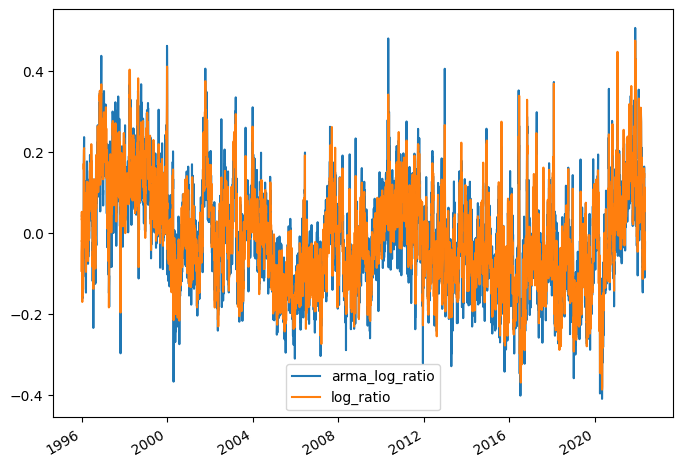

In [51]:
df_preds[['arma_log_ratio', 'log_ratio']].plot(figsize=(8, 6))

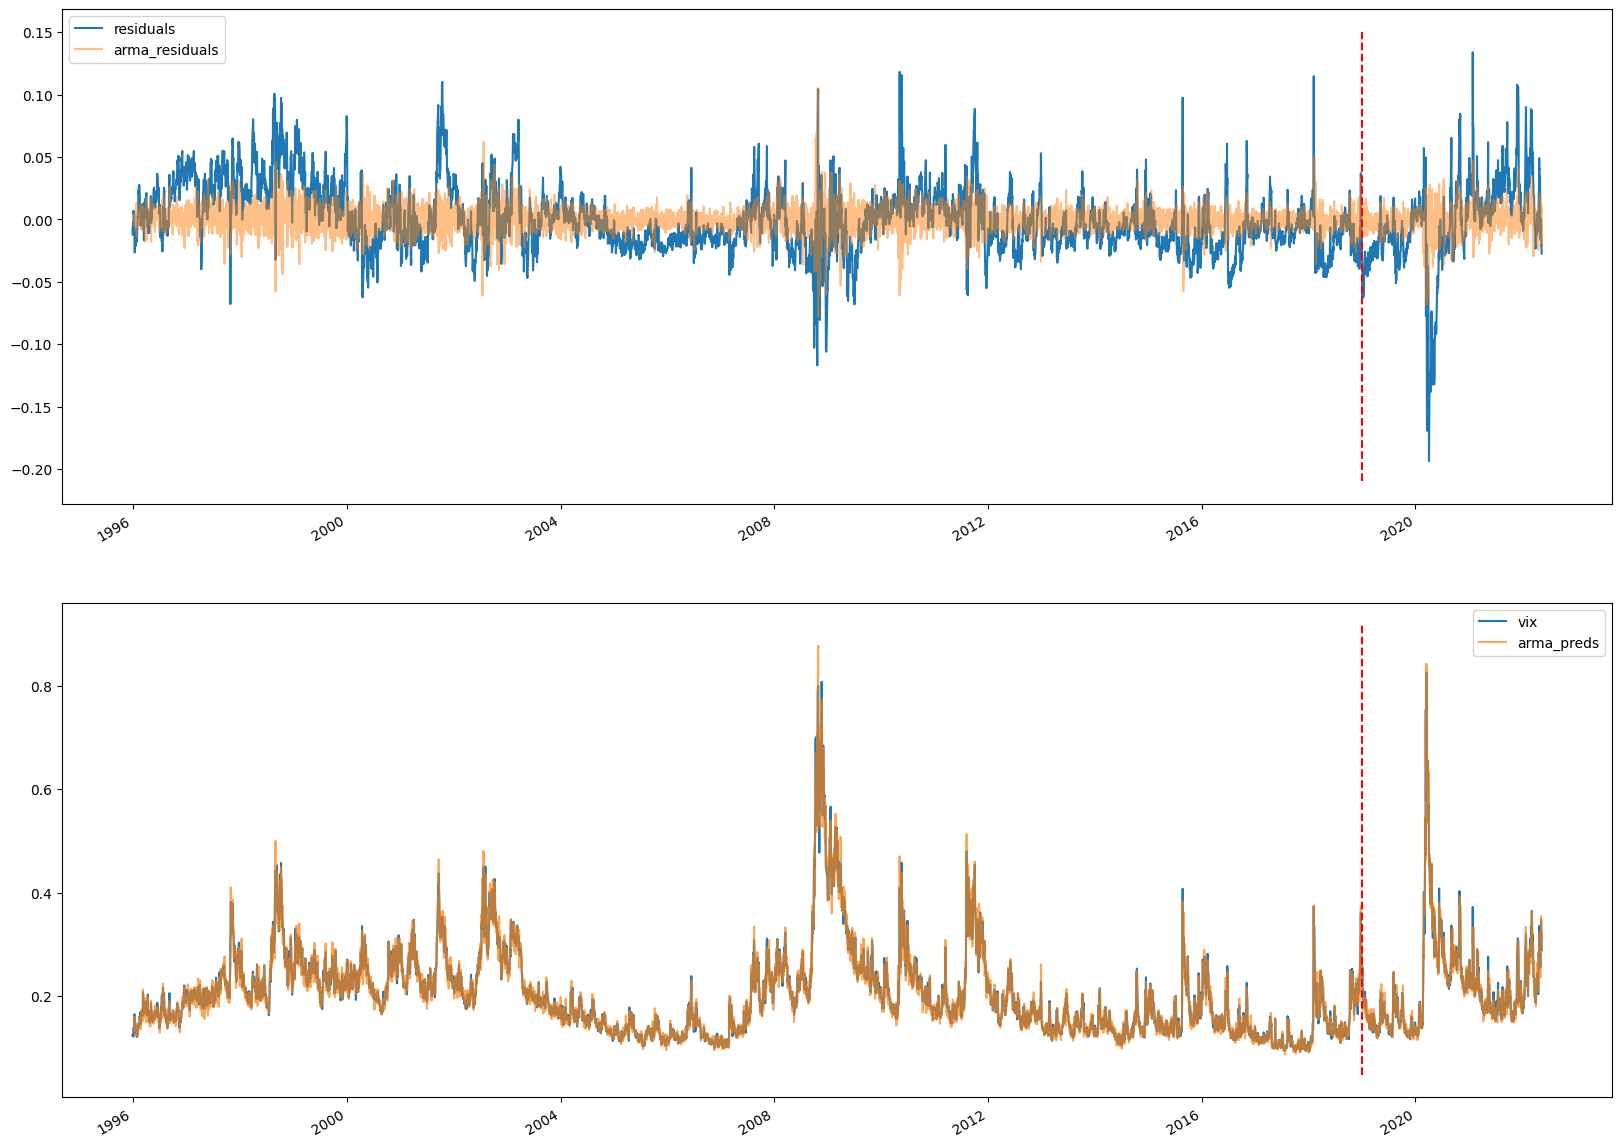

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16))

df_preds[['residuals']].plot(ax=ax[0])
df_preds[['arma_residuals']].plot(ax=ax[0], alpha=0.5)
df_preds[['vix']].plot(ax=ax[1])
df_preds[['arma_preds']].plot(ax=ax[1], alpha=0.7)
ax[0].vlines(test_start_date, ax[0].get_ylim()[0], ax[0].get_ylim()[-1], linestyles='dashed', colors='red')
ax[1].vlines(test_start_date, ax[1].get_ylim()[0], ax[1].get_ylim()[-1], linestyles='dashed', colors='red')

<Axes: >

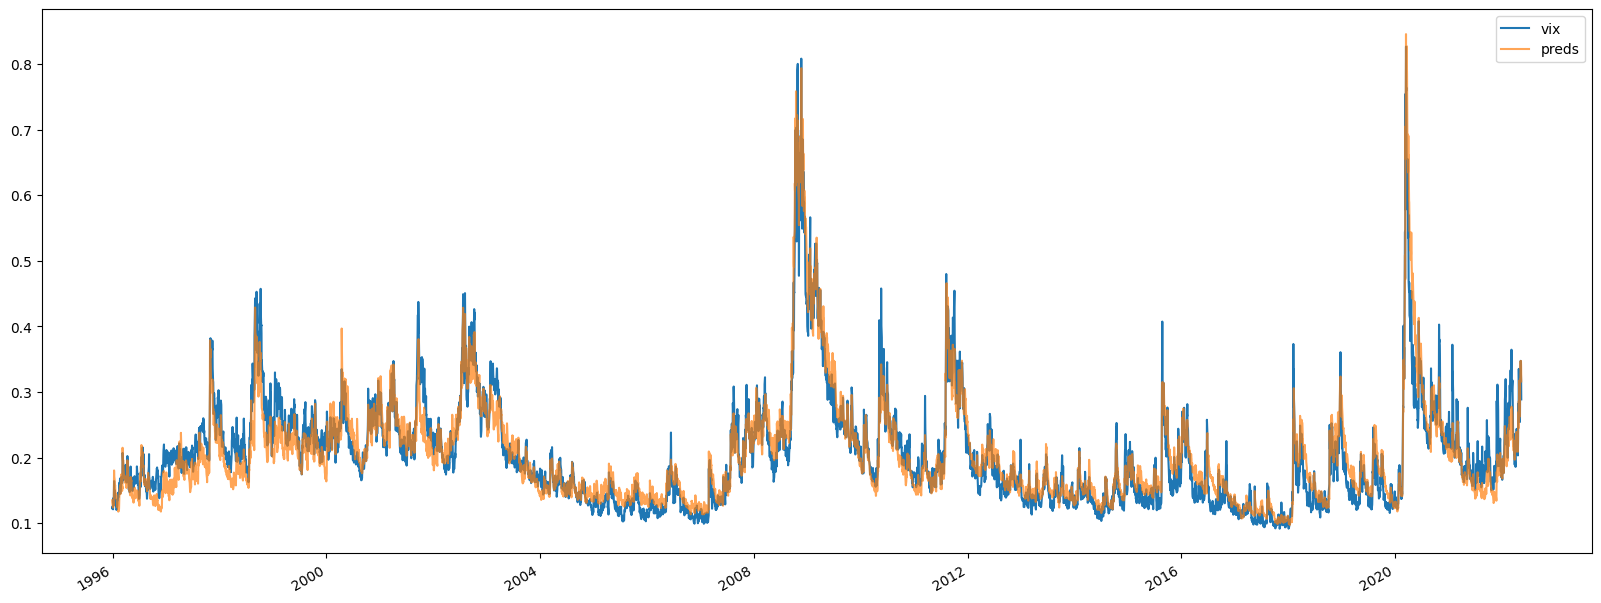

In [53]:
ax = df_preds[['vix']].plot(figsize=(20, 8))
df_preds[['preds']].plot(ax=ax, alpha=0.7)

## Forecast 5000 steps ahead starting from the last available data point

In [54]:
if use_exog == False:
    preds = predict(*res.x, full_data, window, biz_days=biz_days)
    df_preds = full_data[window-1:].copy() # remove data used to calculate first PDV prediction
    df_preds['vix_shift'] = df_preds['vix'].shift(1) # shift use that time t-1 vix is used to predict residual for time t
    df_preds['preds'] = preds
    df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
    df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
    df_preds['log_ratio'] = np.log(df_preds['ratio'])
    df_preds

In [55]:
if use_exog == False:
    y = df_preds['log_ratio'][1:] if use_log_ratio else df_preds['ratio'][1:] # drop the first row because vix_shift is nan
    x = df_preds['vix_shift'][1:]
    if use_exog:
        arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
    else:
        arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
    arma_model_test.distribution = ARCHNormal(seed=seed) # set seed for reproducibility
    fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
    if use_exog:
        sims = fix_res.forecast(horizon=5000, method='simulation', simulations=n_sims, align='origin', x=x) # with vix as exogenous variable
    else:
        sims = fix_res.forecast(horizon=5000, method='simulation', simulations=n_sims, align='origin') # without vix as exogenous variable
    print(sims.simulations.values.shape)
    log_residuals = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
    log_residuals.shape

(1, 9, 5000)


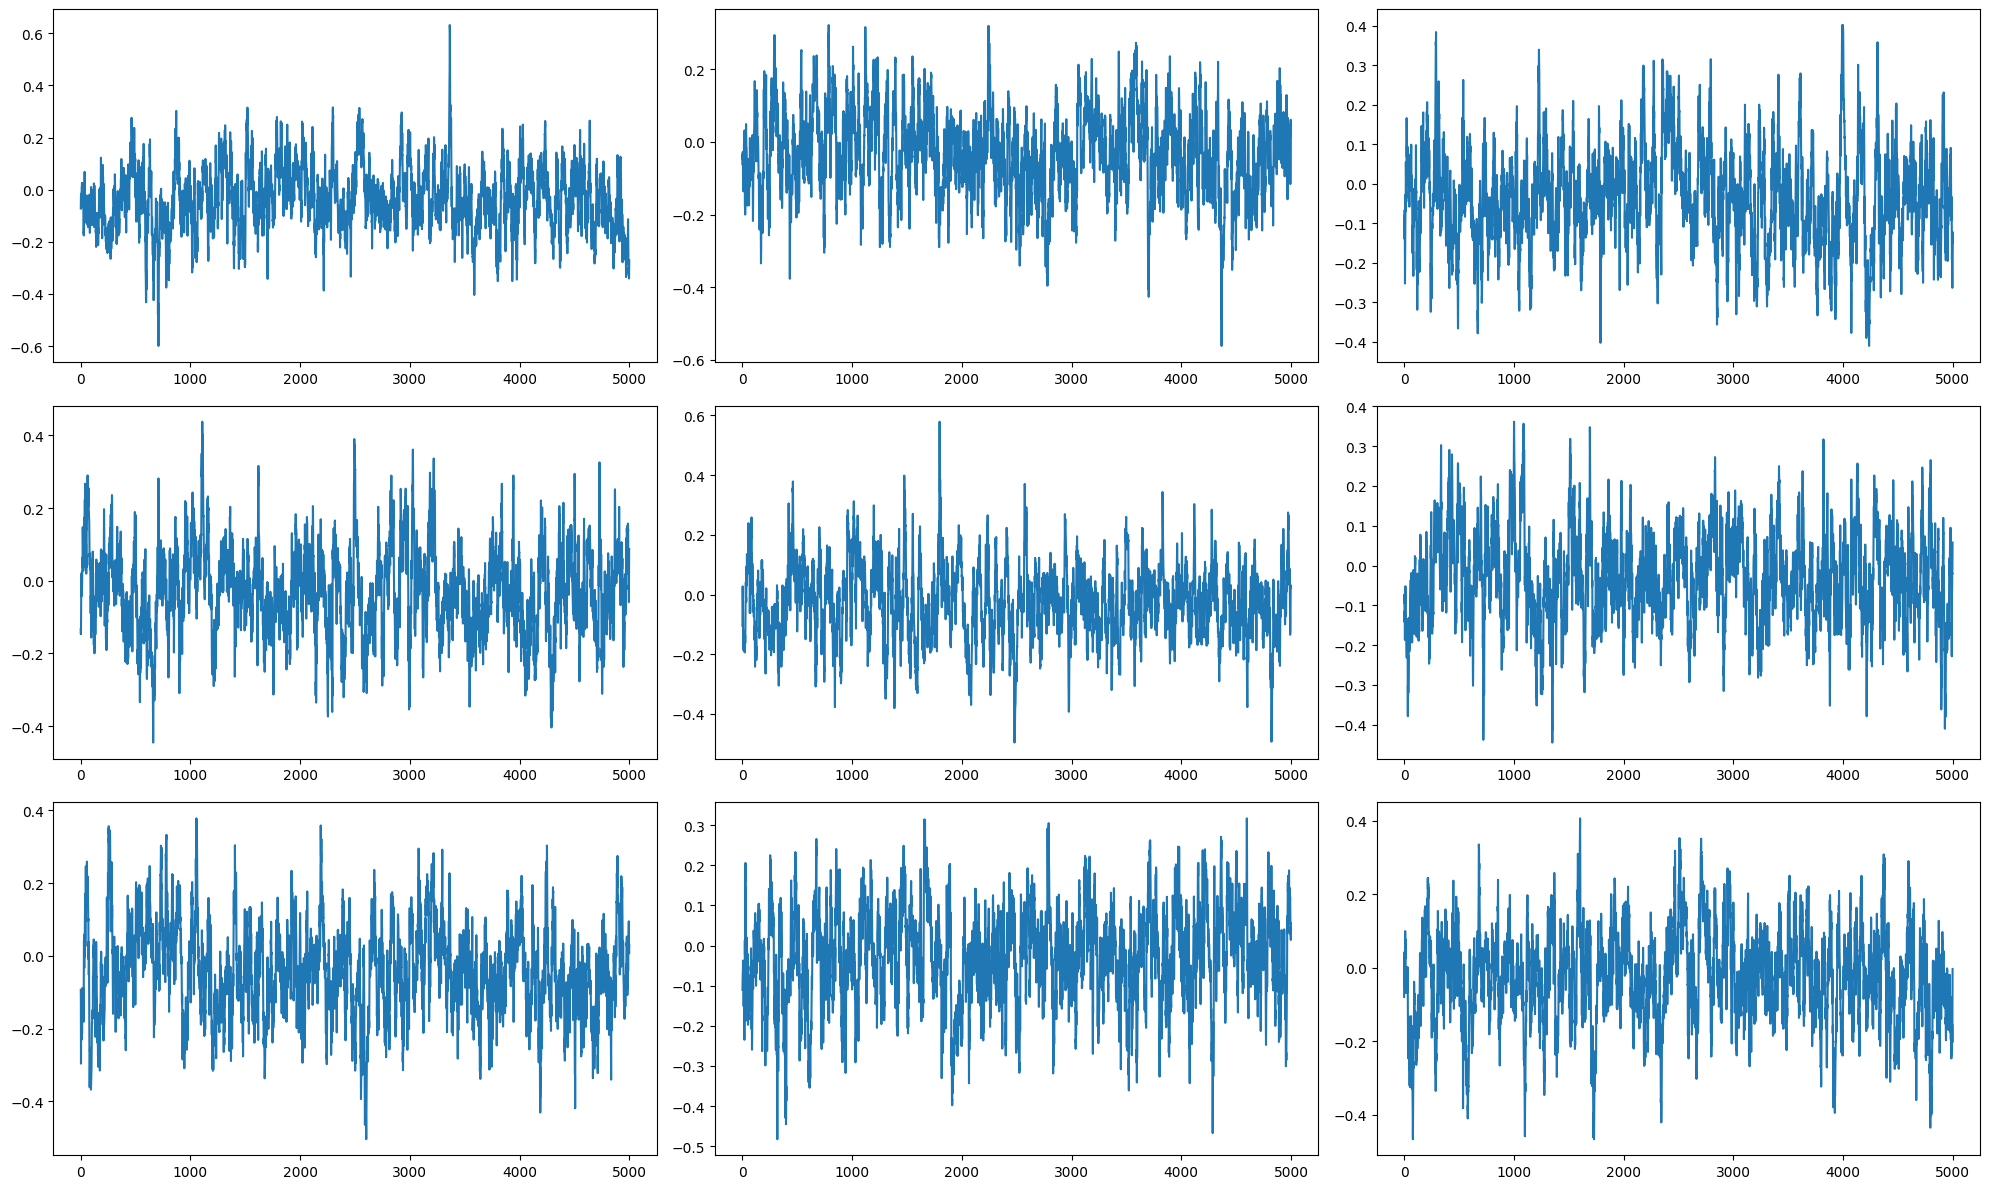

In [56]:
if use_exog == False:
    fig, ax = plt.subplots(max(n_sims//3, 1), min(3, n_sims), figsize=(20, n_sims//3 * 4))
    for i in range(max(n_sims//3, 1)):
        for j in range(min(3, n_sims)):
            try:
                ax[i, j].plot(log_residuals[i*3+j, :]);
            except:
                ax[j].plot(log_residuals[i*3+j, :]);
    plt.tight_layout();

In [57]:
if use_exog == False:
    print(f'Long run mean of log ratio residuals: {arma_res.params[0] / (1 - arma_res.params[1])}')
    print(f'Long run variance of log ratio residuals: {arma_res.params[0]**2 / (1 - arma_res.params[1]**2)}')
    print(f'Long run mean of ratio residuals: {np.exp(arma_res.params[0] / (1 - arma_res.params[1]))}')

Long run mean of log ratio residuals: -0.026172610077445715
Long run variance of log ratio residuals: 2.2869084553934472e-05
Long run mean of ratio residuals: 0.974166924067425


/tmp/ipykernel_28224/1619086677.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Long run mean of log ratio residuals: {arma_res.params[0] / (1 - arma_res.params[1])}')
/tmp/ipykernel_28224/1619086677.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Long run variance of log ratio residuals: {arma_res.params[0]**2 / (1 - arma_res.params[1]**2)}')
/tmp/ipykernel_28224/1619086677.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

## Forecast the full data after starting after the res_window observations using actual historical SPX data and simulated VIX data

In [58]:
preds = predict(*res.x, full_data, window, biz_days=biz_days)
df_preds = full_data[window-1:].copy() # remove data used to calculate first PDV prediction
df_preds['vix_shift'] = df_preds['vix'].shift(1) # shift use that time t-1 vix is used to predict residual for time t
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds.dropna(inplace=True) # drop the first row because vix_shift is nan
df_preds.iloc[max_lag:, -1] = np.NaN
print(f'n_lags: {n_lags}, res_window: {res_window}, max_lag: {max_lag}')
# df_preds.loc[df_preds.index[max_lag-1]:,:]

# # FOR TESTING CUT DF LENGTH
# df_preds = df_preds.iloc[:max_lag+20, :]
# df_preds

n_lags: 1, res_window: 5, max_lag: 5


In [59]:
indices = []
for i in range(100, 0, -1):
    indices.append(df_preds.index[0] - pd.Timedelta(days=i))
temp_df = pd.DataFrame(np.zeros((100, df_preds.shape[1])), columns=df_preds.columns, index=indices)
#temp_df to pad df_preds else arma_model_test.fix() might fail due to insufficient data points even though no estimation is done

if use_exog:
    log_residuals = []
    saved_state = None
    for i in range(n_sims):
        y = df_preds['log_ratio'][:max_lag] if use_log_ratio else df_preds['ratio'][:max_lag]
        y = pd.concat([temp_df['log_ratio'], y]).values # pad temp_df to avoid insufficient data points error
        x = df_preds['vix_shift'][:max_lag]
        x = pd.concat([temp_df['vix_shift'], x]).values # pad temp_df to avoid insufficient data points error
        arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
        arma_model_test.distribution = ARCHNormal(seed=seed) if saved_state is None else ARCHNormal(seed=saved_state) # set seed for reproducibility
        fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
        sims = fix_res.forecast(horizon=1,method='simulation', simulations=1, align='origin', x=x[:,np.newaxis]) # with vix as exogenous variable
        next_y = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
        vix = df_preds.iloc[max_lag, df_preds.columns.get_loc('vix_shift')]
        # print(f'vix: {vix}')
        x = np.concatenate([x, [vix]])
        idx = max_lag
        while idx < len(df_preds):
            # print(f'y.shape: {y.shape}, next_y.shape: {next_y.shape}')
            pred = df_preds.iloc[idx, df_preds.columns.get_loc('preds')]
            vix = pred * np.exp(next_y) if use_log_ratio else pred * next_y # vix at row max_lag = PDV prediction * np.exp(log_ratio) (both also at row max_lag)
            # df_preds.iloc[idx, df_preds.columns.get_loc('arma_multi_step_vix')] = vix # NOTE: for debugging
            # print(f'pred: {pred}, ratio: {np.exp(next_y) if use_log_ratio else next_y}, vix: {vix}, log_ratio: {next_y}')
            y = np.concatenate([y, [next_y]])
            arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
            fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
            sims = fix_res.forecast(horizon=1, method='simulation', simulations=1, align='origin', x=x[:,np.newaxis])
            next_y = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
            # print(f'x.shape: {x.shape}, vix.shape: {vix.shape}')
            x = np.concatenate([x, [vix]])
            idx += 1
        log_residuals.append(y[len(temp_df)+max_lag:] if use_log_ratio else np.log(y[len(temp_df)+max_lag:])) # remove the padded and the first max_lag rows
        # saved_state = arma_model_test.distribution.random_state # random_state is deprecated
        saved_state = np.random.default_rng(saved_state)
    log_residuals = np.array(log_residuals)
    print(log_residuals.shape)
else:
    y = df_preds['log_ratio'][:max_lag] if use_log_ratio else df_preds['ratio'][:max_lag]
    y = pd.concat([temp_df['log_ratio'], y]) # pad temp_df to avoid insufficient data points error
    arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
    arma_model_test.distribution = ARCHNormal(seed=seed) # set seed for reproducibility
    fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
    sims = fix_res.forecast(horizon=len(df_preds)-max_lag, method='simulation', simulations=n_sims, align='origin') # without vix as exogenous variable
    print(sims.simulations.values.shape)
    log_residuals = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
    print(log_residuals.shape)

(1, 9, 6635)
(9, 6635)


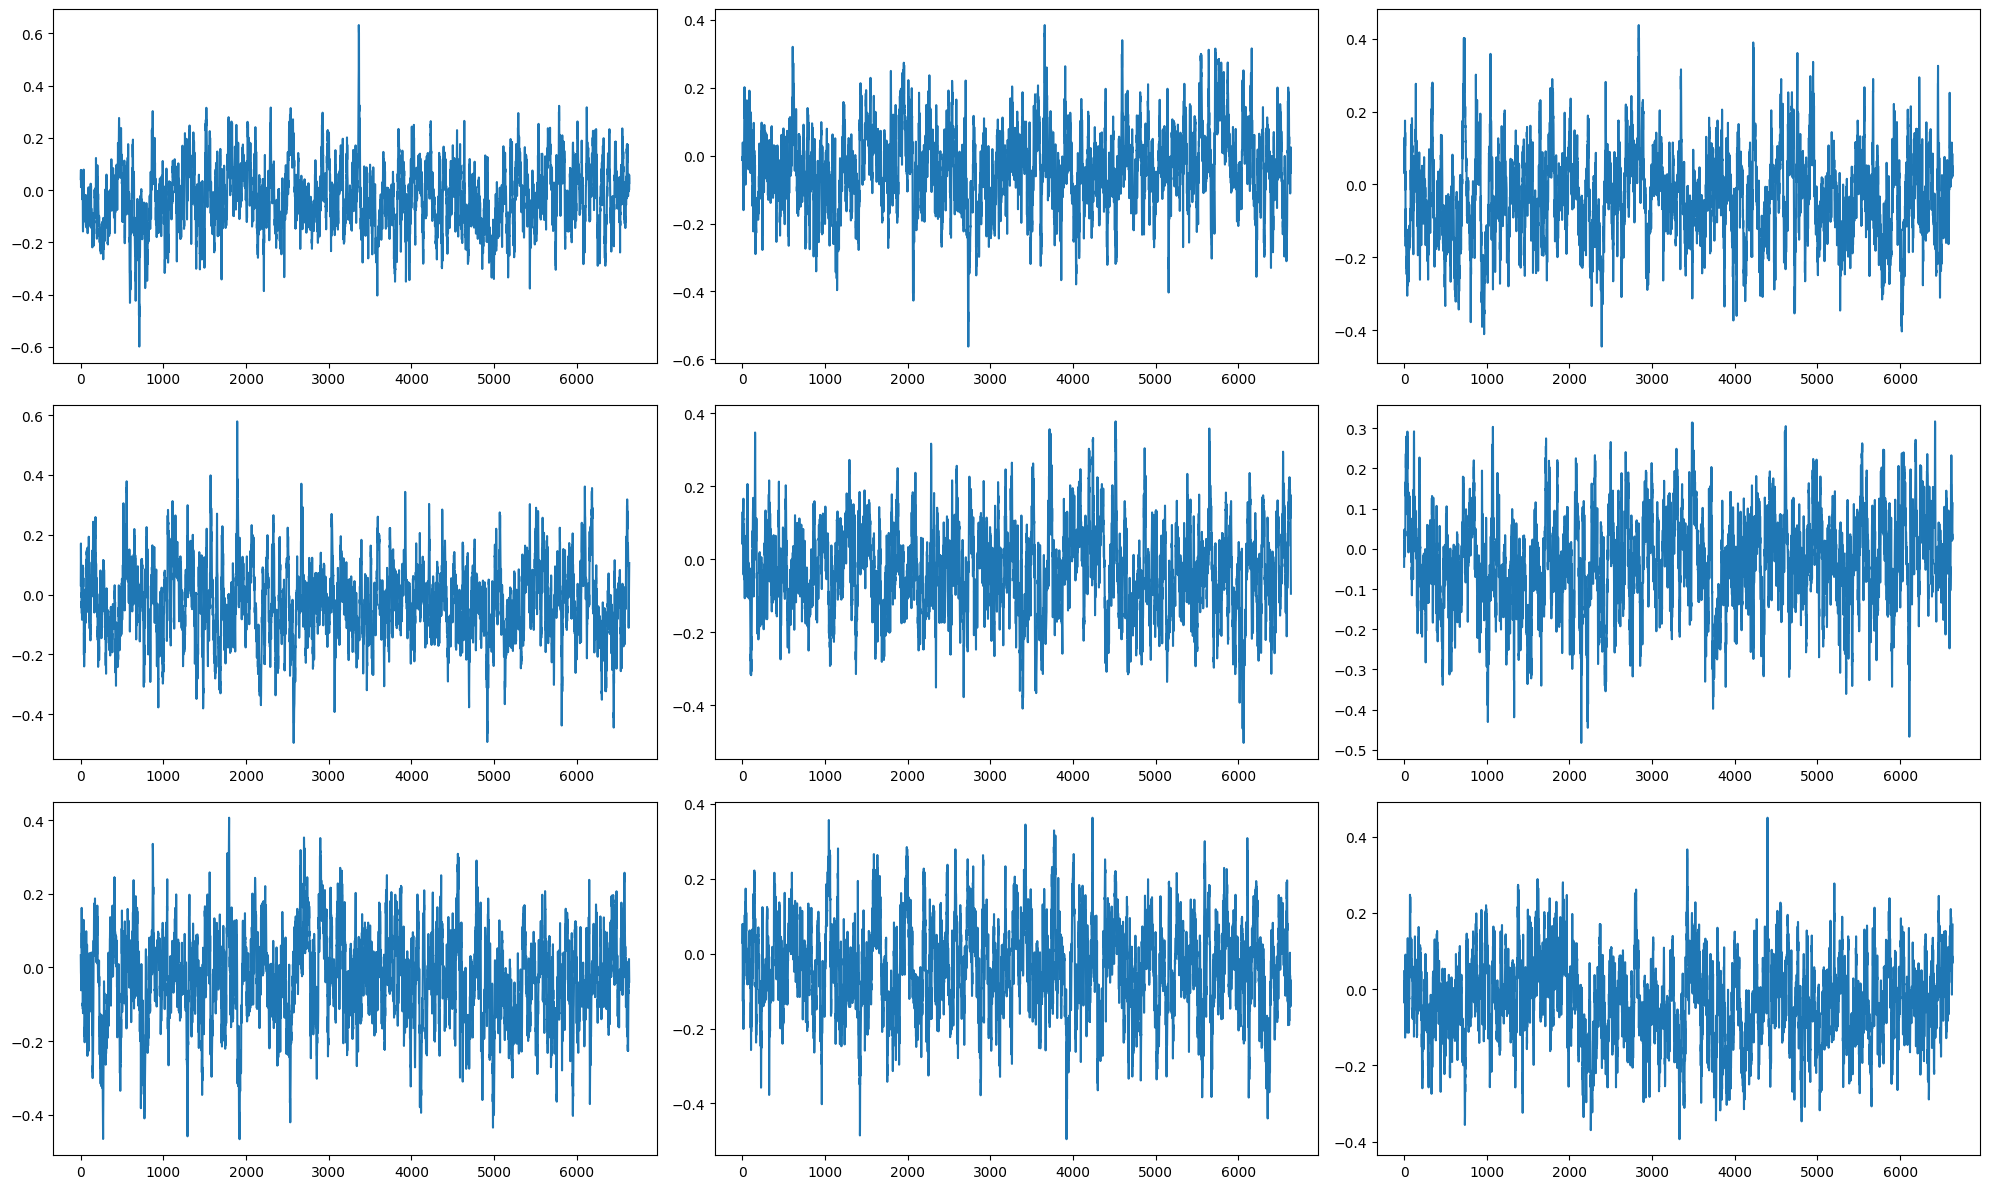

In [60]:
fig, ax = plt.subplots(max(n_sims//3, 1), min(3, n_sims), figsize=(20, n_sims//3 * 4))
for i in range(max(n_sims//3, 1)):
    for j in range(min(3, n_sims)):
        try:
            ax[i, j].plot(log_residuals[i*3+j, :]);
        except:
            ax[j].plot(log_residuals[i*3+j, :]);
plt.tight_layout();

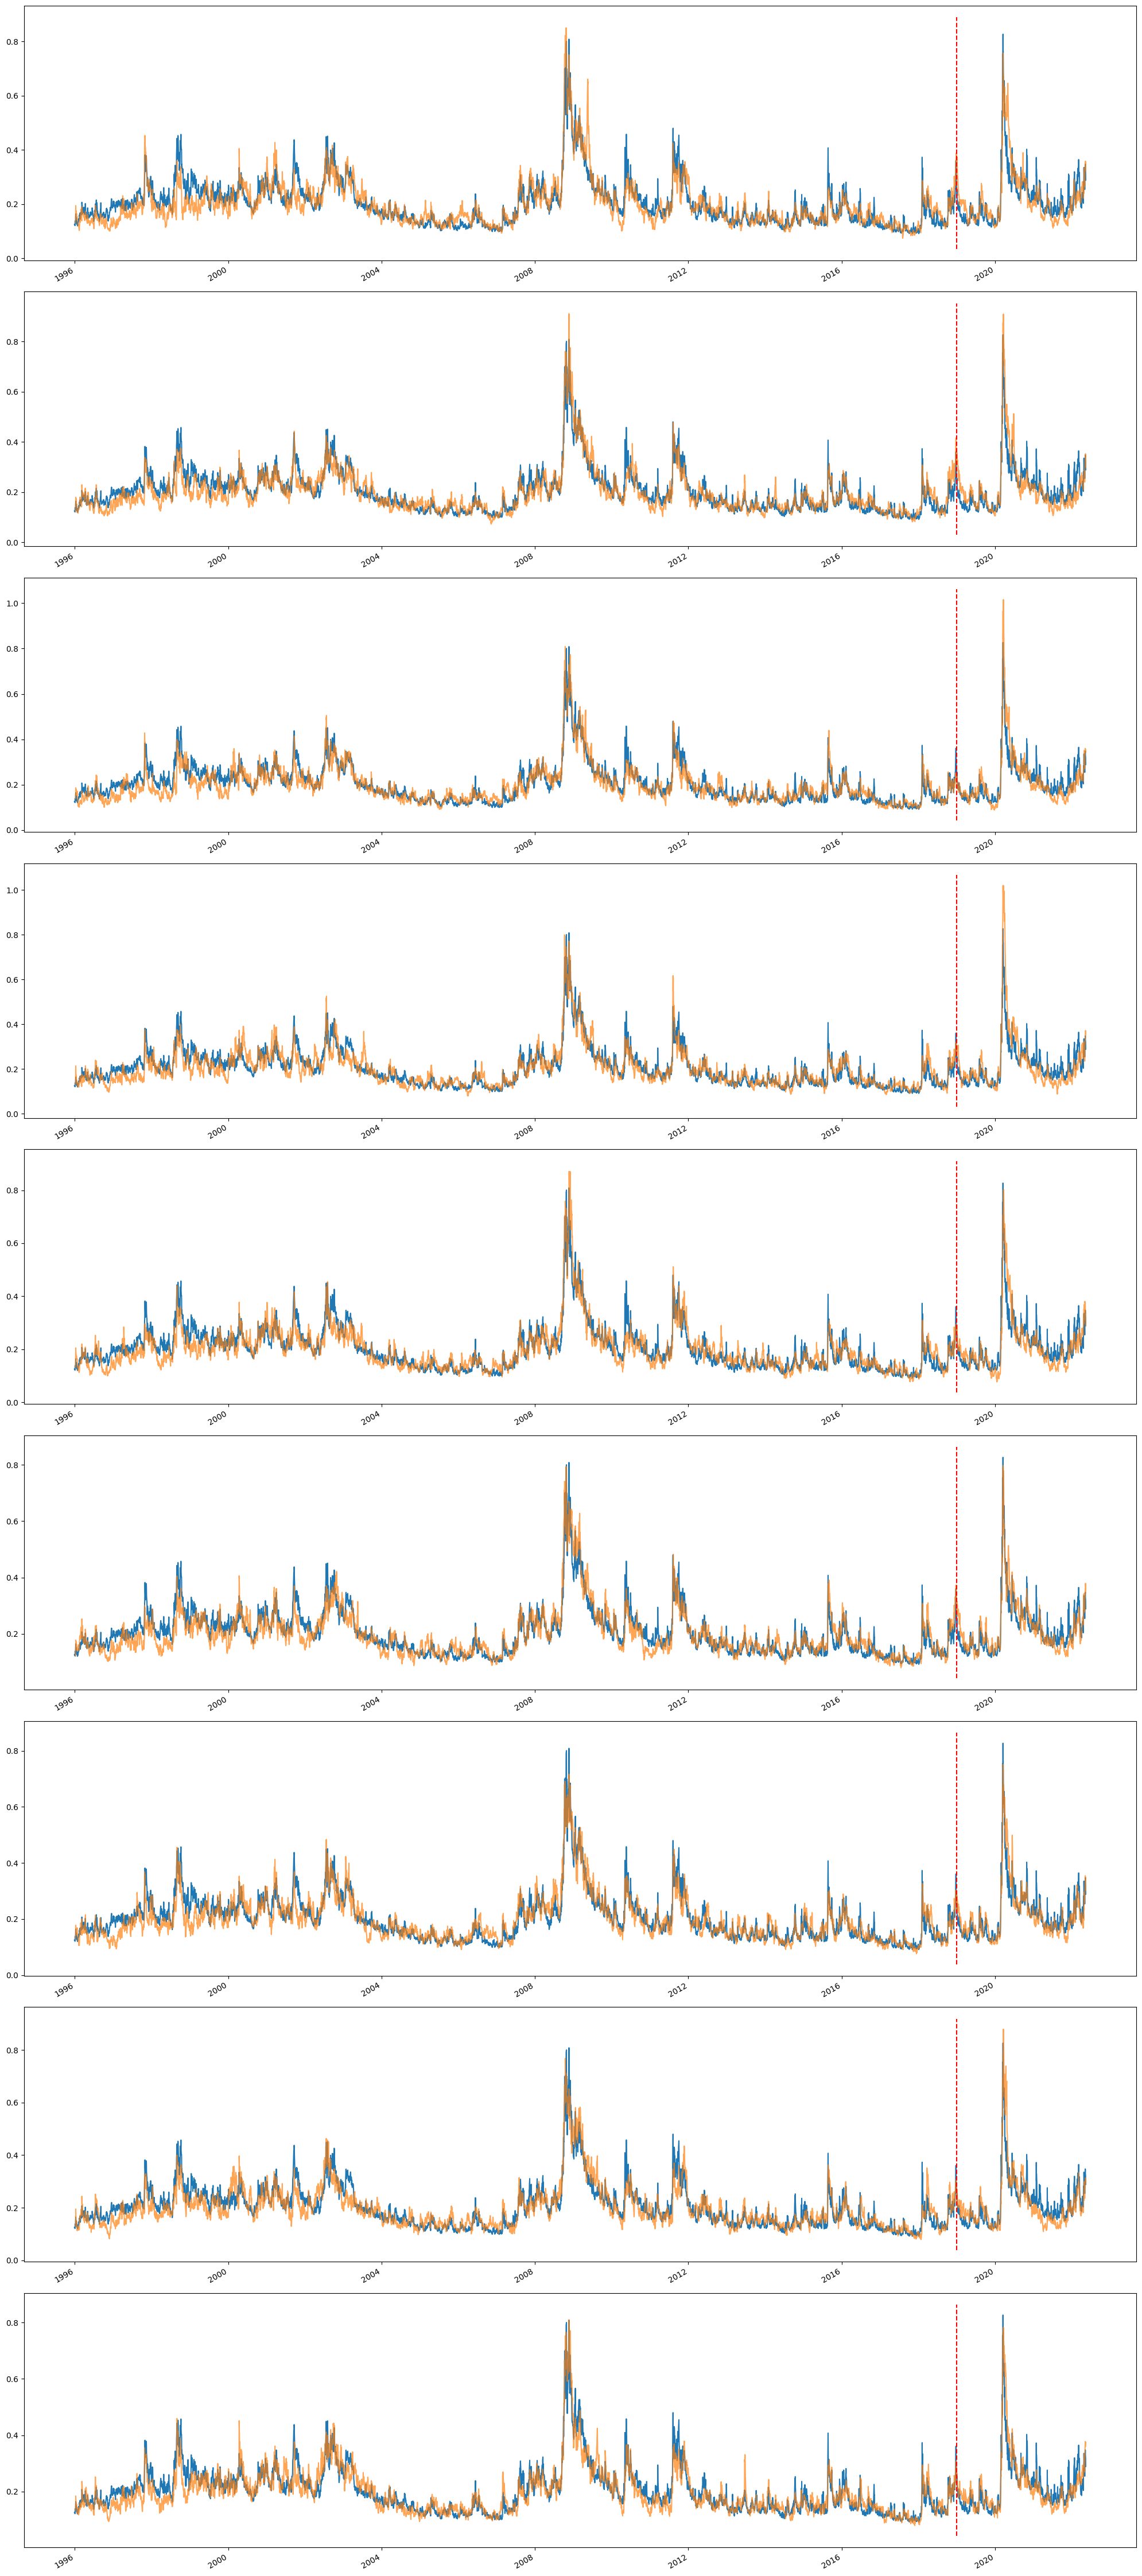

In [61]:
fig, ax = plt.subplots(n_sims, 1, figsize=(20, n_sims*5))
for i in range(n_sims):
    df_preds['arma_multi_step_log_ratio'] = np.NaN
    df_preds.iloc[max_lag:, df_preds.columns.get_loc('arma_multi_step_log_ratio')] = log_residuals[i, :]
    df_preds['arma_multi_step_preds'] = np.exp(df_preds['arma_multi_step_log_ratio']) * df_preds['preds']
    df_preds['arma_multi_step_residuals'] = df_preds['vix'] - df_preds['arma_multi_step_preds']
    df_preds['vix'].plot(ax=ax[i], alpha=1.0)
    df_preds['arma_multi_step_preds'].plot(ax=ax[i], alpha=0.7)
    ax[i].vlines(test_start_date, ax[i].get_ylim()[0], ax[i].get_ylim()[-1], linestyles='dashed', colors='red')
plt.tight_layout();

In [62]:
df_preds[max_lag-2:]

,r1,r2,vix,vix_shift,preds,residuals,ratio,log_ratio,arma_multi_step_log_ratio,arma_multi_step_preds,arma_multi_step_residuals
1996-01-04,-0.005843,0.000034,0.1378,0.1210,0.130906,0.006894,1.052666,0.051326,NaN,NaN,NaN
1996-01-05,-0.001604,0.000003,0.1358,0.1378,0.131656,0.004144,1.031478,0.030993,NaN,NaN,NaN
1996-01-08,0.002834,0.000008,0.1311,0.1358,0.126342,0.004758,1.037656,NaN,0.047205,0.132449,-0.001349
1996-01-09,-0.014676,0.000215,0.1521,0.1311,0.150849,0.001251,1.008290,NaN,0.006798,0.151878,0.000222
1996-01-10,-0.018164,0.000330,0.1640,0.1521,0.180250,-0.016250,0.909848,NaN,0.020053,0.183901,-0.019901
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,0.001060,0.3475,0.3019,0.347259,0.000241,1.000695,NaN,0.083469,0.377488,-0.029988
2022-05-10,0.002455,0.000006,0.3299,0.3475,0.334988,-0.005088,0.984811,NaN,0.068016,0.358565,-0.028665
2022-05-11,-0.016600,0.000276,0.3256,0.3299,0.346673,-0.021073,0.939213,NaN,0.071573,0.372395,-0.046795
2022-05-12,-0.001297,0.000002,0.3177,0.3256,0.337916,-0.020216,0.940175,NaN,0.088537,0.369198,-0.051498
